! This file has problems running on laptop, run on workstation instead

In [1]:
import xarray as xr
import pyproj
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cmocean as cmo
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy as np
import copy
import sys

sys.path.append('../src')
import utils as ut

In [2]:
run = 'n011'

ds = xr.open_dataset(f'../data/temperature_{run}.nc')
basin = ds.basin
ttime = ds.time
tbas = ds.temp
ds.close()

ds = xr.open_dataset(f'../data/basinmask.nc')
lon = ds.lon
lat = ds.lat
mask = ds.mask
ds.close()

#From Eveline:
rean = np.array([0.5,-0.3,1.4,-0.8,-0.2])
rstd = np.array([0.2,0.3,0.2,0.2,0.2]) #dummy

In [3]:
ds = xr.open_dataset('../data/temperature_cmip6.nc')
ctime = ds.time
ctbas = ds.temp
ds.close()

In [4]:
mpl.rcParams['figure.subplot.wspace'] = .2
mpl.rcParams['figure.subplot.left'] = .1
mpl.rcParams['figure.subplot.right'] = .9
mpl.rcParams['figure.figsize'] = (7,5)

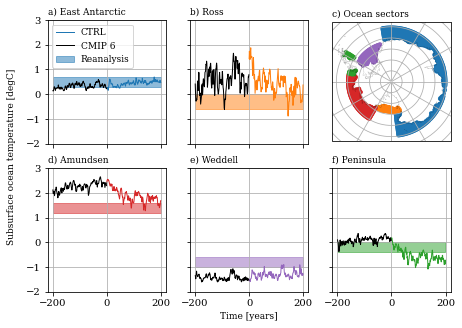

In [5]:

nax = [1,2,4,5,6]

fig = plt.figure()

ax = fig.add_subplot(233,projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -63], crs=ccrs.PlateCarree())
for b,bas in enumerate(basin.values):
    im = ax.scatter(lon,lat,15*np.nansum(mask[b,:,:,:],axis=0),c=ut.bcol[bas],transform=ccrs.PlateCarree(),label=bas,lw=0,alpha=1)
ax.coastlines(lw=.1)
ax.set_title('c) Ocean sectors',loc='left')
#ax.legend(bbox_to_anchor=(-.02,-.15),loc='lower left',ncol=5,markerscale=2,columnspacing=.05,handletextpad=-.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=False)
gl.xlocator = mticker.FixedLocator(np.arange(-180,210,30))
gl.xformatter = LONGITUDE_FORMATTER

for b,bas in enumerate(basin.values):
    ax = fig.add_subplot(2,3,nax[b])
    temp = tbas.sel(basin=bas)
    ax.plot(ttime,temp,c=ut.bcol[bas],lw=1,label='CTRL')
    
    ax.plot(ctime,ctbas.sel(basin=bas),color='k',lw=1,label='CMIP 6')
    ax.plot([ctime[-1],ttime[0]],[
    
    ax.fill_between([ctime[0],ttime[-1]],[rean[b],rean[b]]-rstd[b],[rean[b],rean[b]]+rstd[b],color=ut.bcol[bas],alpha=.5,clip_on=False,label='Reanalysis')
    
    ax.set_title(ut.btitle[bas],loc='left')

    if nax[b] == 1:
        ax.legend(loc='upper left')
    
    if nax[b] == 5:
        ax.set_xlabel('Time [years]')
    ax.grid(True)
    if nax[b] in [1,2]:
        ax.set_xticklabels([])
    if nax[b] != 3:
        ax.set_ylim([-2,3])
    if nax[b] not in [1,4]:
        ax.set_yticklabels([])

fig.supylabel('Subsurface ocean temperature [degC]',fontsize=9)

plt.savefig(f'../draftfigs/ts_control.png',dpi=450)
plt.show()